In [1]:
%pylab inline
from pyspark import SparkContext, SparkConf
np.set_printoptions(precision=3, suppress=True)
import numpy as np
import os
import time
start_time = time.time()
from VAT import VAT
from iVAT import iVAT
from dissimilarity import dissimilarity

Populating the interactive namespace from numpy and matplotlib


In [2]:
# INPUTS TO ALGORITHM
set_selector = 25 # This number selects a UCR time series. 76 is a big one.
cl_est = 5        # Initial guess of number of clusters.
sample_ratio = 0.25

# If checking algorithmic performance all additional printing, figure display
# options will be removed.
test_run = True
optimised = True

# Data input - assumes this is done externally - not considered part of complexity.
datapath = 'UCR_TS_Archive_2015/'
datadirlist = os.listdir(datapath)
datadirlist.sort()
datadir = datapath+datadirlist[set_selector]+'/'
datafile = [i for i in os.listdir(datadir) if 'TEST' in i]
f = file(datadir+datafile[0])

# Array of time series data. This is a poor way of doing it because it means the series must be 
# storable in memory before being converted to a RDD.
ts = np.genfromtxt(f, delimiter = ',')
numSeries = len(ts)
num_samples = np.ceil(numSeries * sample_ratio)
len_series = len(ts[0])
len_series_pow2 = np.power(2,int(np.ceil(np.log2(len_series))))
ts_rows = [i for i in range(numSeries)]
for i in range(numSeries):
    ts_rows[i] = i, np.append(ts[i,1:], np.zeros(len_series_pow2-len_series))
    
preprocessing_time = time.time()

In [3]:
timeSeriesRDD = sc.parallelize(ts_rows,numSlices=3)

In [4]:
# Create RDD consisting of indexed dissimilarity arrays of each time series.
# Can select 'euclidian', 'NCC', or 'DTW' as distance metric.
NCC_rowmat = dissimilarity(timeSeriesRDD,numSeries=numSeries,metric='euclidean')

dissim_mat_time = time.time()

In [5]:
if sample_ratio != 1.0: 
    # Start to develop clusiVAT - essentially have a matrix at this point.

    # Deteriming cluster seed points - distinguished objects.
    # This whole section has almost no paralellisation. Required to calculate immediately.
    # How can it be further parallelised?
    # Initialise the algorithm by choosing the first instance / row.
    m = np.zeros(cl_est)  # index of distinguished points
    clus_seed = m[0]
    y1 = NCC_rowmat.filter(lambda row: row[0] == clus_seed).collect() # Just collects first row.
    
    dissim_mat_time = time.time()
    
    # Then we have this non-deterministic iteration which requires constant 
    # communication back to the RDD looking for the row corresponding to the 
    # last distinguished point that is required for the next distinguished point.
    # Demonstrate that this part is actually dependent on that parameter selection.
    # Entirely dependent on the communications of this algorithm.
    # Use the seed row to generate distinguished instance index array, m.
    # How could this be just done on each node then sent back and reassembled?
    # Justifying a modification is going to require some kind of proof wrt to MST...
    for i in range(1,cl_est):
        #y2 = NCC_rowmat.filter(lambda x: x[0] == m[i-1]).cache().collect()
        y2 = NCC_rowmat.filter(lambda x: x[0] == m[i-1]).collect()
        y_min = np.minimum(y1[0][1],y2[0][1])
        m[i] = np.argmax(y_min)

    m = np.unique(m).astype(int)
    if not test_run: print m
    disting_inst_time = time.time()
else:
    dissim_mat_time = time.time()
    disting_inst_time = dissim_mat_time

In [6]:
if not test_run and False: 
    # This defines an array containing the cluster index.
    # Each row should be kept on one node (reasonable?)
    # It needs to have the row ID and the cluster key --> sampling is done based
    # on the cluster key --> map function chooses each cluster and sample randomly.
    # THIS IS NOT A NECESSARY STEP - JUST REQUIRED TO CHECK COUNT OF INPUT DATA.
    #proto_clust = NCC_rowmat.map(lambda (ind, row): (np.argmin(row[m]), (ind, row)))
    proto_clust = NCC_rowmat.map(lambda (ind, row): (np.argmin(row[m]), ind))

    # Count number of instances in each protocluster.
    proto_clust_cnt = proto_clust.combineByKey((lambda row: 1),(lambda comb,row: comb+1),(lambda comb1, comb2: comb1+comb2))
    
    print proto_clust_cnt.collect()
    #print proto_clust.take(5)
    #print proto_clust.collect()

In [7]:
if sample_ratio != 1.0: 
    # Chooses a random selection of points for each distinguished object.
    # COLLECT: Need to have a key-value pairs that are capable of returning a reduced dissimilarity matrix.
    # - Requires 
    # So each
    fractions = {i: sample_ratio for i in range(len(m))}

    # This sampling just selects each item with certain probability.
    # Fails to meet the criterium of selecting a proportional amount.
    # May need to take into account the partitioning here to ensure that it is done correctly...
    # This will approach the right value as the set size increases??
    NCC_rowmat_sample = NCC_rowmat.map(lambda (ind, row): (np.argmin(row[m]), (ind, row))
                                      ).sampleByKey(False,fractions)
    
    # This test proved that every time this is evaluated it produces a different sample (der)
    #test1 = NCC_rowmat_sample.collect()
    #test2 = NCC_rowmat_sample.collect()

    # THIS IS NOT A NECESSARY STEP BUT NEEDED TO VERIFY SAMPLE FRACTION.
    #if not test_run: 
    #    sample_cnt = NCC_rowmat_sample.combineByKey(
    #        (lambda row: 1),(lambda comb,row: comb+1),(lambda comb1, comb2: comb1+comb2))
    #    print sample_cnt.collect()
else:
    NCC_rowmat_sample = NCC_rowmat.map(lambda (ind, row): (0, (ind, row)))
    if not test_run: print NCC_rowmat_sample.take(5)


In [8]:
# This will minimise comms by only sending back the dissimilarity data that is required for the reduced matrix.
# Is sorting required??
# THIS IS THE DISSIMILARITY MATRIX
# sample_ind.sort()

NCC_matrix = NCC_rowmat_sample.map(lambda (clus, row): (row[0],row[1])).collect()

sample_time = time.time()

NCC_matrix.sort(key = lambda tup: tup[0])

sample_ind = np.array([i[0] for i in NCC_matrix])

if not test_run: print NCC_matrix

In [9]:
NCC_mat_final = np.vstack(tuple(i[1][sample_ind] for i in NCC_matrix))

if not test_run: print NCC_mat_final

In [10]:
end_time = time.time()


In [11]:
#R_VAT, I_VAT, C = VAT(NCC_mat_final)

D_iVAT, D_VAT, I_VAT, C, d = iVAT(NCC_mat_final)

eendtime = time.time()

pre_time = preprocessing_time - start_time
build_dissim_mat = dissim_mat_time - preprocessing_time
id_dist_inst = disting_inst_time - dissim_mat_time
map_rows_to_seed = sample_time - disting_inst_time
produce_matrix = end_time - sample_time

runtime = end_time - start_time

vattime = eendtime - end_time

#print 'Input time series have '+str(rowpart)+' partitions.'
#print 'Full cartesian product has '+str(NCCrowpart)+' partitions.'
#print 'Combined rows of NCC values have '+str(NCCrowmatpart)+' partitions.'

print('')

print("Pre-processing time = %s seconds ---" % pre_time)
print("Unordered dissimilarity matrix development = %s seconds ---" % build_dissim_mat)
print("Find distinguishing instances = %s seconds ---" % id_dist_inst)
print("Map to prototype cluster = %s seconds ---" % map_rows_to_seed)
print("Produce sampled matrix =  %s seconds ---" % produce_matrix)
print("Total dissimilarity time =  %s seconds ---" % runtime)
print("Total iVAT time =  %s seconds ---" % vattime)

print('')

print([set_selector,cl_est,sample_ratio,build_dissim_mat,id_dist_inst,map_rows_to_seed,produce_matrix,vattime])


Pre-processing time = 0.455237150192 seconds ---
Unordered dissimilarity matrix development = 12.9075369835 seconds ---
Find distinguishing instances = 1.7227230072 seconds ---
Map to prototype cluster = 1.02801394463 seconds ---
Produce sampled matrix =  0.047905921936 seconds ---
Total dissimilarity time =  16.1614170074 seconds ---
Total iVAT time =  0.395242929459 seconds ---

[25, 5, 0.25, 12.90753698348999, 1.7227230072021484, 1.0280139446258545, 0.047905921936035156, 0.39524292945861816]


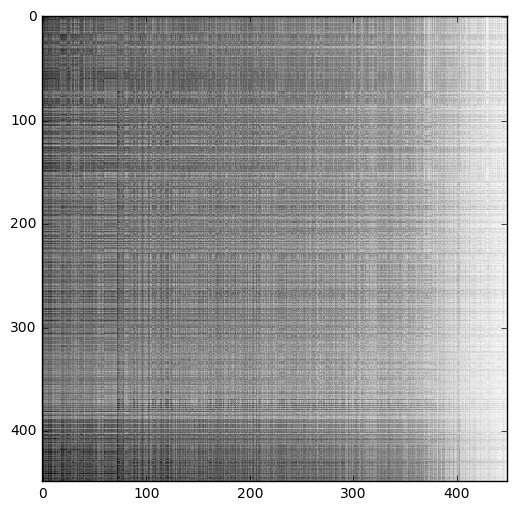

In [12]:
#figure(figsize=(6,6))
#plt.imshow(R_VAT,cmap='Greys_r',interpolation='none');

figure(figsize=(6,6))
plt.imshow(NCC_mat_final,cmap='Greys_r',interpolation='none');

figure(figsize=(6,6))
plt.imshow(D_VAT,cmap='Greys_r',interpolation='none');

figure(figsize=(6,6))
plt.imshow(D_iVAT,cmap='Greys_r',interpolation='none');

In [13]:
#numpy.savetxt('VAT_matrix.csv', D_VAT, delimiter=',')
#numpy.savetxt('test_matrix_quarter.csv', NCC_mat_final, delimiter=',')

/home/sparker/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


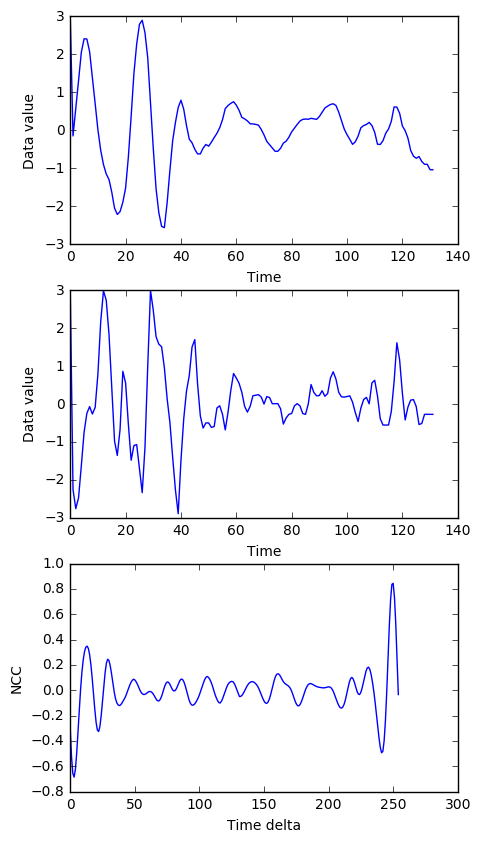

In [14]:
# For presentation

figure(figsize=(5,10))
subplot(3,1,1)
plot(ts[250].T)
plt.axis([None,None,-3,3])
plt.xlabel('Time')
plt.ylabel('Data value')
subplot(3,1,2)
plot(ts[268].T)
plt.axis([None,None,-3,3])
plt.xlabel('Time')
plt.ylabel('Data value')
subplot(3,1,3)
plt.plot(np.fft.ifft(np.fft.fft(ts_rows[250][1]/np.linalg.norm(ts_rows[250][1])) *
                     np.conj(np.fft.fft(ts_rows[270][1]/np.linalg.norm(ts_rows[270][1])))))
plt.xlabel('Time delta')
plt.ylabel('NCC')